# Transfer learning
TL of Alexnet with XGBoost as classifier applied to galaxy pictures dataset

In [71]:
import os
from IPython.display import display, clear_output

from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Extract features out of convolutional layer

In [2]:
torch.multiprocessing.set_sharing_strategy('file_system')

# Load model
model = models.alexnet(pretrained=True)
print(model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [4]:
# Define training and test data directories
data_dir = 'data/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

In [5]:
# Image to tensor
def preprocess(img):  
    img = img.resize((224,224)).convert('RGB')
    tensor = transforms.ToTensor()(img)
    return tensor

# Load training data and fit to alexnet data
train = datasets.ImageFolder(train_dir, transform=preprocess)
test = datasets.ImageFolder(test_dir, transform=preprocess)

print('Num training images: ', len(train))
print('Num test images: ', len(test))

Num training images:  352
Num test images:  48


In [6]:
# generate data loaders
batch_size = 20
num_workers = 0
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [63]:
def extract_features(data_loader, output_path):
    
    num_batch = len(data_loader)
    count = 0
    try:
        os.remove(output_path) # to erase previous version as it is mode 'a'
    except FileNotFoundError:
        pass

    # extract features on a single line for each image
    for batch, labels in data_loader:

        feature_list = []
        label_list = []

        for idx, img in enumerate(batch):
            features_extracted = model.features(img.reshape((1, 3, 224, 224)))
            feature_list.append(features_extracted.detach().numpy().reshape((256 * 6 * 6)))
            label_list.append(labels[idx].item())

        row_features = pd.DataFrame(data=feature_list)
        row_label = pd.DataFrame(data=label_list, columns=['label'])
        row = pd.concat([row_features, row_label], axis=1)  
        row.to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)
        count += 1

        # display progress
        clear_output(wait=True)
        file_size = os.path.getsize(output_path)
        print('batch %d/%d, %s file size: %.3f Mo'%(count, num_batch, output_path,  file_size/10**6))

In [64]:
%%time 
train_path = 'data/train_features.csv'
extract_features(train_loader, train_path)

batch 18/18, data/train_features.csv file size: 19.852 Mo
Wall time: 57.9 s


In [65]:
%%time 
test_path = 'data/test_features.csv'
extract_features(test_loader, test_path)

batch 3/3, data/test_features.csv file size: 2.781 Mo
Wall time: 7.9 s


## Train XGB classifier

In [68]:
# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train = np.array(train_df[train_df.columns[~train_df.columns.isin(['label'])]])
y_train = np.array(train_df['label'])
X_test = np.array(test_df[test_df.columns[~test_df.columns.isin(['label'])]])
y_test = np.array(test_df['label'])

In [69]:
# Size of sets
print("X Train set:",X_train.shape)
print("y Train set:",y_train.shape)
print("X Test set:",X_test.shape)
print("y Test set:",y_test.shape)

X Train set: (352, 9216)
y Train set: (352,)
X Test set: (48, 9216)
y Test set: (48,)


In [99]:
%%time
# Cross-validator 
sss = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 42)

# Define classifier
clf = xgb.XGBClassifier()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ('XGB',clf)
])   

# parameters to tune 
param_grid = {
    'XGB__n_estimators': [100, 150],
    'XGB__learning_rate': [0.01, 0.001]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

# training classifier
grid.fit(X_train, y_train)

# best classifier
clf = grid.best_estimator_

# predicition with the classifier
y_pred = clf.predict(X_test)

# print grid best parameters
print (grid.best_params_)

# save classifier
torch.save(model, 'data/tl_model_xgb.pth')

# classification report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 10.2min finished


{'XGB__learning_rate': 0.01, 'XGB__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.33      0.17      0.22        12
           2       0.57      0.67      0.62        12
           3       0.64      0.75      0.69        12

    accuracy                           0.58        48
   macro avg       0.55      0.58      0.56        48
weighted avg       0.55      0.58      0.56        48

Wall time: 11min 1s


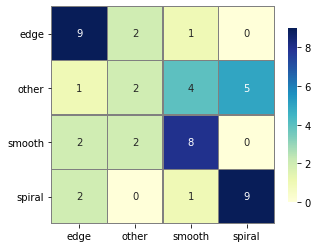

In [100]:
# Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.columns = os.listdir('data/train')
cm.index = os.listdir('data/train')

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm, 
    cmap='YlGnBu', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d',
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right');